In [1]:
# Test per Abaco

# Obiettivo: prevedere la sopravvivenza o meno dei passeggeri in base alle loro caratteristiche

# Pacchetti

from IPython.display import display, Markdown, Latex, HTML

# Analisi e manipolazione

import numpy as np
import pandas as pd
import missingno
from collections import Counter

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import learning_curve, cross_val_score, validation_curve, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
gs = pd.read_csv("gender_submission.csv")

In [3]:
# si comincia con una data exploration nel dataset di train, per analizzare le caretteristiche dei passeggeri in relazione alla sopravvivenza

print(train.head())
print(train.isnull().sum())


   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
Pa

In [4]:
print(test.head())
print(test.isnull().sum())

   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin 

In [5]:
# la colonna Cabin contiene molti NA. In più, visto che non viene specificatala posizione delle cabine, è meglio eliminare la colonna.
# i codice dei biglietti, i nomi dei passeggeri e il luogo dove si sono imbarcati li ritengo irrilevanti al fine dell'analisi.

train = train.drop(['Cabin','Ticket','Name'], axis=1)
test = test.drop(['Cabin','Ticket','Name'], axis=1)

In [6]:
#sostituisco la variabile del sesso con una categorica (M=0, F=1)

train['Sex'] = train['Sex'].map({'male':0, 'female':1})
test['Sex'] = test['Sex'].map({'male':0, 'female':1})

In [7]:
# sostituisco il NA di Fare rispettivamente in Test con la media del valore della variabile

mean = test['Fare'].dropna().mean()
mean

35.6271884892086

In [8]:
test['Fare'].fillna(mean, inplace=True)

print(train.isnull().sum())
print(test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64
PassengerId     0
Pclass          0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            0
Embarked        0
dtype: int64


In [9]:
# Sostituisco la variabile d'imbarco con una variabile dummy a seconda del porto

train = pd.get_dummies(train, columns = ['Embarked'], prefix = 'Emb')
test = pd.get_dummies(test, columns = ['Embarked'], prefix = 'Emb')

print(train.head())
print(test.head())

   PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Emb_C  \
0            1         0       3    0  22.0      1      0   7.2500      0   
1            2         1       1    1  38.0      1      0  71.2833      1   
2            3         1       3    1  26.0      0      0   7.9250      0   
3            4         1       1    1  35.0      1      0  53.1000      0   
4            5         0       3    0  35.0      0      0   8.0500      0   

   Emb_Q  Emb_S  
0      0      1  
1      0      0  
2      0      1  
3      0      1  
4      0      1  
   PassengerId  Pclass  Sex   Age  SibSp  Parch     Fare  Emb_C  Emb_Q  Emb_S
0          892       3    0  34.5      0      0   7.8292      0      1      0
1          893       3    1  47.0      1      0   7.0000      0      0      1
2          894       2    0  62.0      0      0   9.6875      0      1      0
3          895       3    0  27.0      0      0   8.6625      0      0      1
4          896       3    1  22.0      

In [10]:
# creo una variabile per individuare se un passeggero viaggia da solo o in famiglia e, in quest'ultimo caso, il numero dei componenti del nucleo famigliare

train['FamSize'] = train['Parch'] + train['SibSp'] + 1

test['FamSize'] = test['Parch'] + train['SibSp'] + 1


In [11]:
# di seguito ne creo un'altra categorica per indicare se il viaggiatore era solo o in famiglia

train['Alone'] = 0
train.loc[train['FamSize'] == 1, 'Alone'] = 1

test['Alone'] = 0
test.loc[test['FamSize'] == 1, 'Alone'] = 1

In [12]:
print(train.head())
print(test.head())

   PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Emb_C  \
0            1         0       3    0  22.0      1      0   7.2500      0   
1            2         1       1    1  38.0      1      0  71.2833      1   
2            3         1       3    1  26.0      0      0   7.9250      0   
3            4         1       1    1  35.0      1      0  53.1000      0   
4            5         0       3    0  35.0      0      0   8.0500      0   

   Emb_Q  Emb_S  FamSize  Alone  
0      0      1        2      0  
1      0      0        2      0  
2      0      1        1      1  
3      0      1        2      0  
4      0      1        1      1  
   PassengerId  Pclass  Sex   Age  SibSp  Parch     Fare  Emb_C  Emb_Q  Emb_S  \
0          892       3    0  34.5      0      0   7.8292      0      1      0   
1          893       3    1  47.0      1      0   7.0000      0      0      1   
2          894       2    0  62.0      0      0   9.6875      0      1      0   
3        

<AxesSubplot:xlabel='SibSp', ylabel='Count'>

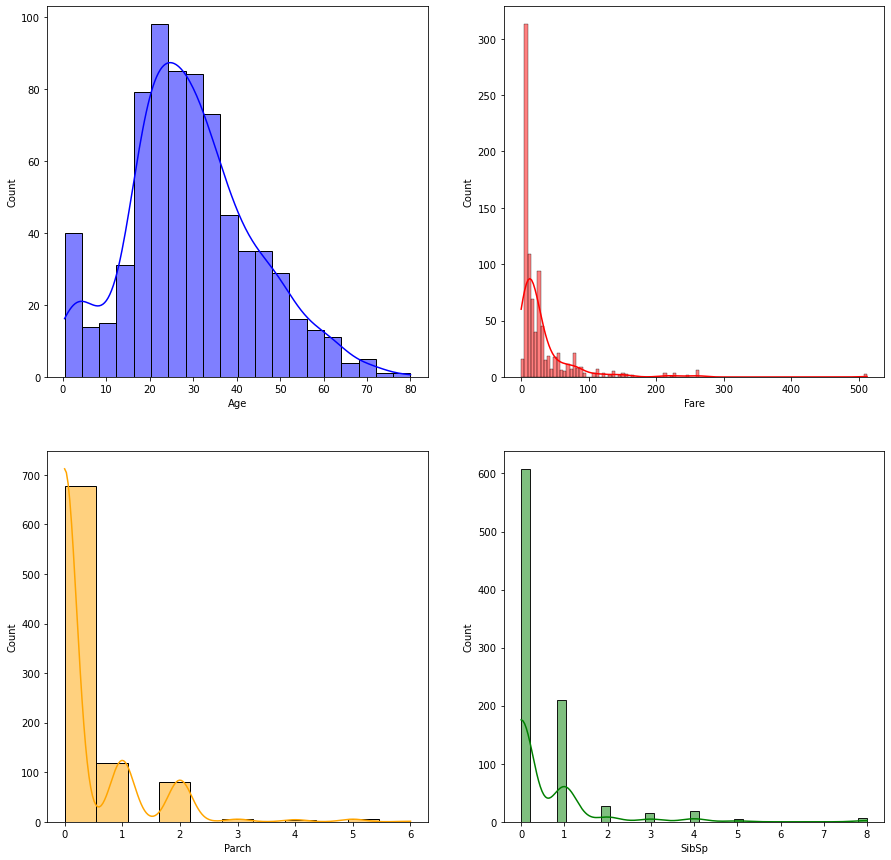

In [13]:
# un altro step consiste nella rimozione degli outliers nelle 4 variabili numeriche (Age, Fare, Parch,SibSp), i quali potrebbero rovinare le future analisi
# si inizia con uno sguardo alle distribuzioni, e a seconda che siano normali o spostate verso dx/sx, si applicare il rispettivo metodo di rimozione degli outliers

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

sns.histplot(data=train, x="Age", kde=True, color="blue", ax=axs[0, 0])
sns.histplot(data=train, x="Fare", kde=True, color="red", ax=axs[0, 1])
sns.histplot(data=train, x="Parch", kde=True, color="orange",ax=axs[1, 0])
sns.histplot(data=train, x="SibSp", kde=True, color="green",ax=axs[1, 1])

In [14]:
# procedo con la l'identificazione degli outliers, le distribuzioni sono spostate a sx. Questa procedura la applico solo al dataset di train

def detectout(df, n, features):
    outlier_id = []
    for col in features:
        q1 = np.percentile(df[col],25)
        q3 = np.percentile(df[col],75)
        iqr = q3-q1
        outlier_step = 1.5*iqr
        low_limit = q1-outlier_step
        high_limit = q3+outlier_step
        outlier_list_col = df[(df[col] < low_limit) | (df[col] > high_limit)].index
        outlier_id.extend(outlier_list_col)
    outlier_id = Counter(outlier_id)
    multiple_outliers = list(key for key, value in outlier_id.items() if value > n) 
    return multiple_outliers

outliers = detectout(train, 2, ['Age','Fare','Parch','SibSp'])
print('outliers'.format(len(outliers)),outliers)
    

outliers [27, 88, 159, 180, 201, 324, 341, 792, 846, 863]


In [15]:
# ora la rimozione

print(train.count(axis=0))

train = train.drop(outliers, axis=0).reset_index(drop=True)

print(train.count(axis=0))

PassengerId    891
Survived       891
Pclass         891
Sex            891
Age            714
SibSp          891
Parch          891
Fare           891
Emb_C          891
Emb_Q          891
Emb_S          891
FamSize        891
Alone          891
dtype: int64
PassengerId    881
Survived       881
Pclass         881
Sex            881
Age            711
SibSp          881
Parch          881
Fare           881
Emb_C          881
Emb_Q          881
Emb_S          881
FamSize        881
Alone          881
dtype: int64


<AxesSubplot:xlabel='Pclass', ylabel='count'>

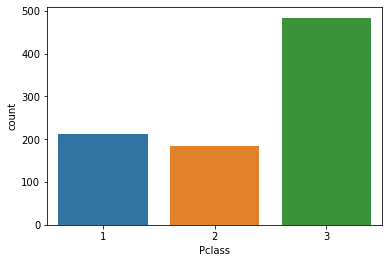

In [16]:
# un primo fattore di interesse potrebbe essere la classe dei passeggeri

sns.countplot(x="Pclass", data=train)

Pclass  Survived
1       0            79
        1           134
2       0            97
        1            87
3       0           365
        1           119
Name: Survived, dtype: int64


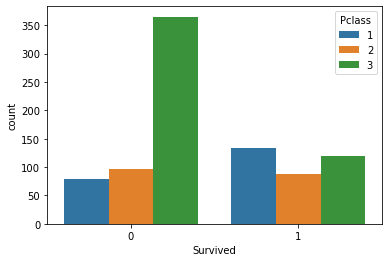

In [17]:
# proviamo a incrociare il numero dei passeggeri per ogni classe con le vittime/sopravvissuti

sns.countplot(x="Survived", data=train, hue="Pclass") 

print(train.groupby(["Pclass","Survived"])["Survived"].count())

# le vittime si trovano principalmente tra i passeggeri della terza classe, mentre quelli della prima sono quelli che relativamente si contano di più tra i sopravvissuti.

AxesSubplot(0.125,0.125;0.775x0.755)
Pclass  Sex
1       0      121
        1       92
2       0      108
        1       76
3       0      343
        1      141
Name: Sex, dtype: int64


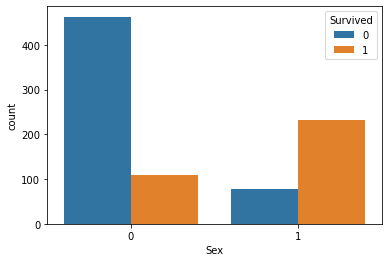

In [18]:
# un altro fattore che si può analizzare è il sesso dei passeggeri

print(sns.countplot(x="Sex", data=train, hue="Survived"))

print(train.groupby(["Pclass","Sex"])["Sex"].count())

AxesSubplot(0.125,0.125;0.775x0.755)
Pclass  Sex  Survived
1       0    0            76
             1            45
        1    0             3
             1            89
2       0    0            91
             1            17
        1    0             6
             1            70
3       0    0           296
             1            47
        1    0            69
             1            72
Name: Survived, dtype: int64


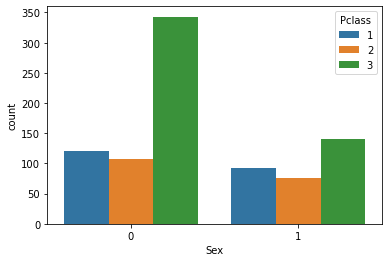

In [19]:
# da analizzare, ora, è la relazione tra sesso, sopravvissuti e classe corrispondente

print(sns.countplot(x="Sex", data=train, hue="Pclass"))

print(train.groupby(["Pclass",'Sex',"Survived"])["Survived"].count())

# le vittime sono perlopiù uomini

C:\Users\loren\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\loren\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


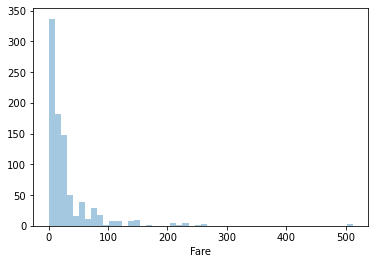

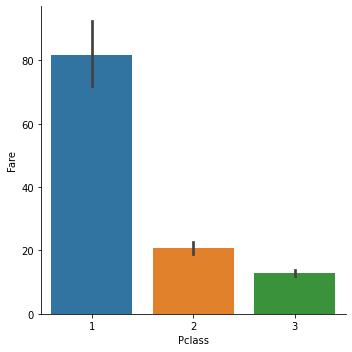

In [20]:
# sempre tenendo in considerazione la classe, un elemento corrispondente è sicuramente la tariffa del biglietto

sns.distplot(train["Fare"], kde=False)

sns.factorplot(y='Fare',x='Pclass', kind='bar', data=train)

# com'era prevedibile, i biglietti più costosi sono riservati alla prima classe e quelli più venduti hanno prezzi inferiori riservati alla seconda e terza classe

C:\Users\loren\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age'>

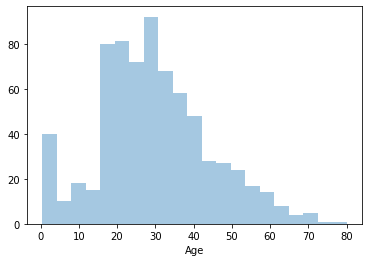

In [21]:
# un altro fattore di interesse potrebbe essere l'età

sns.distplot(train["Age"], kde=False)

# dall'istogramma si nota che i sopravvissuti hanno principalmente un'età compresa tra i 20 e i 40 anni, mentre il numero di anziani sopravvissuti è significamente inferiore

C:\Users\loren\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\loren\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


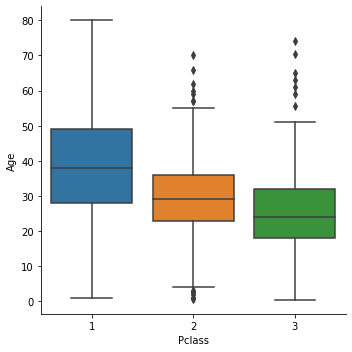

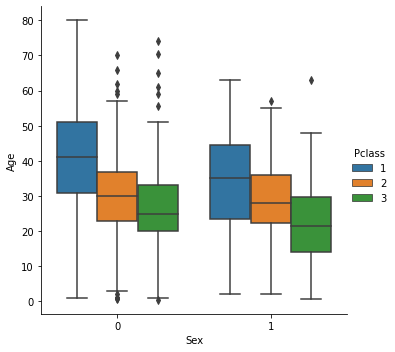

In [22]:
# proviamo ora ad incrociare le due variabili analizzate in precedenza tramite un boxplot

sns.factorplot(x="Pclass", y="Age", kind='box', data=train)

sns.factorplot(y='Age',x='Sex',hue='Pclass', kind='box', data=train)

# si può notare come l'età media dei passeggeri in prima classe sia superiore alle altre due, sia negli uomini che nelle donne. Tuttavia, anche tramite l'istogramma della precedente distribuzione, si notano pochi passeggeri in età avanzata

C:\Users\loren\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\loren\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


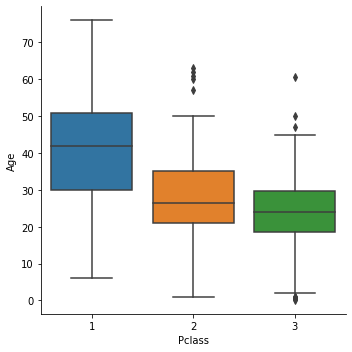

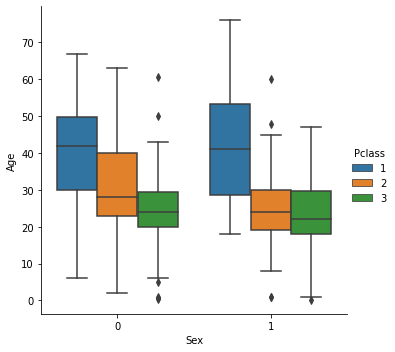

In [23]:
sns.factorplot(x="Pclass", y="Age", kind='box', data=test)

sns.factorplot(y='Age',x='Sex',hue='Pclass', kind='box', data=test)

# le caratteristiche precedenti si riscontrano anche nel dataset di test, ma con una maggiore distirbuzione dei passeggeri della prima classe

In [24]:
# la colonna Age contiene molti NA. Le opzioni sono due, o eliminare le righe o sostituire gli NA con il valore di età medio per ciascuna classe
# preferisco la seconda opzione per mantenere invariato il numero dei morti/sopravvissuti

print(train[train['Pclass']==1]['Age'].mean())
print(train[train['Pclass']==2]['Age'].mean())
print(train[train['Pclass']==3]['Age'].mean())

38.49956284153006
29.87763005780347
25.14061971830986


In [25]:
def fillAgeNaTrain(cols):
    age=cols[0]
    pclass=cols[1]
    
    if pd.isnull(age):
        if pclass == 1:
            return round(train[train['Pclass']==1]['Age'].mean()) 
        elif pclass == 2:
            return round(train[train['Pclass']==2]['Age'].mean())
        elif pclass == 3:
            return round(train[train['Pclass']==3]['Age'].mean())
    else:
        return age
                         
train['Age'] = train[['Age','Pclass']].apply(fillAgeNaTrain, axis=1)                    

In [26]:
# ripeto per il dataset di test
print(test[test['Pclass']==1]['Age'].mean())
print(test[test['Pclass']==2]['Age'].mean())
print(test[test['Pclass']==3]['Age'].mean()) 

40.91836734693877
28.7775
24.02794520547945


In [27]:
def fillAgeNaTest(cols):
    age=cols[0]
    pclass=cols[1]
    
    if pd.isnull(age):
        if pclass == 1:
            return round(test[test['Pclass']==1]['Age'].mean())
        elif pclass == 2:
            return round(test[test['Pclass']==2]['Age'].mean())
        elif pclass == 3:
            return round(test[test['Pclass']==3]['Age'].mean())
    else:
        return age
                         
test['Age'] = test[['Age','Pclass']].apply(fillAgeNaTest, axis=1)  

   PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Emb_C  \
0            1         0       3    0  22.0      1      0   7.2500      0   
1            2         1       1    1  38.0      1      0  71.2833      1   
2            3         1       3    1  26.0      0      0   7.9250      0   
3            4         1       1    1  35.0      1      0  53.1000      0   
4            5         0       3    0  35.0      0      0   8.0500      0   

   Emb_Q  Emb_S  FamSize  Alone  
0      0      1        2      0  
1      0      0        2      0  
2      0      1        1      1  
3      0      1        2      0  
4      0      1        1      1  
PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Emb_C          0
Emb_Q          0
Emb_S          0
FamSize        0
Alone          0
dtype: int64


C:\Users\loren\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\loren\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


   PassengerId  Pclass  Sex   Age  SibSp  Parch     Fare  Emb_C  Emb_Q  Emb_S  \
0          892       3    0  34.5      0      0   7.8292      0      1      0   
1          893       3    1  47.0      1      0   7.0000      0      0      1   
2          894       2    0  62.0      0      0   9.6875      0      1      0   
3          895       3    0  27.0      0      0   8.6625      0      0      1   
4          896       3    1  22.0      1      1  12.2875      0      0      1   

   FamSize  Alone  
0      2.0      0  
1      2.0      0  
2      1.0      1  
3      2.0      0  
4      2.0      0  
PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Emb_C          0
Emb_Q          0
Emb_S          0
FamSize        0
Alone          0
dtype: int64


C:\Users\loren\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\loren\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


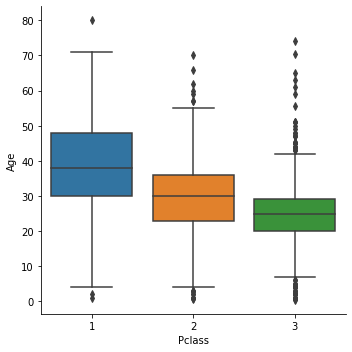

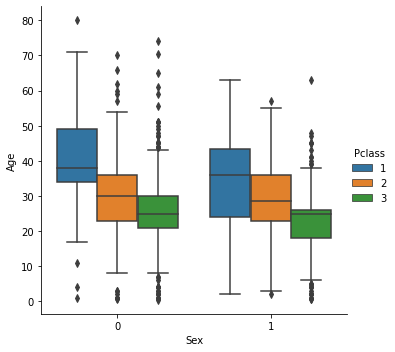

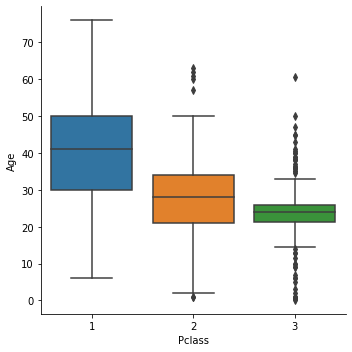

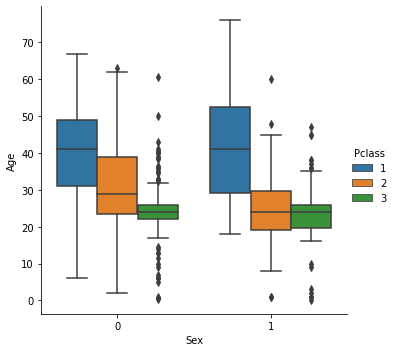

In [28]:
# check del risultato finale
print(train.head())
print(train.isnull().sum())

sns.factorplot(x="Pclass", y="Age", kind='box', data=train)

sns.factorplot(y='Age',x='Sex',hue='Pclass', kind='box', data=train)

print(test.head())
print(test.isnull().sum())

sns.factorplot(x="Pclass", y="Age", kind='box', data=test)

sns.factorplot(y='Age',x='Sex',hue='Pclass', kind='box', data=test)


# la distribuzione non sembra significativamente alterata

C:\Users\loren\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\loren\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


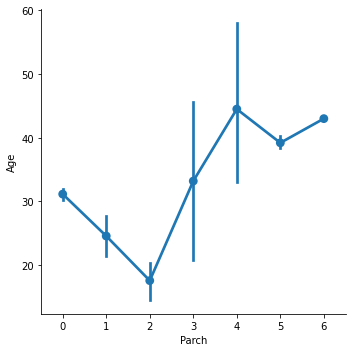

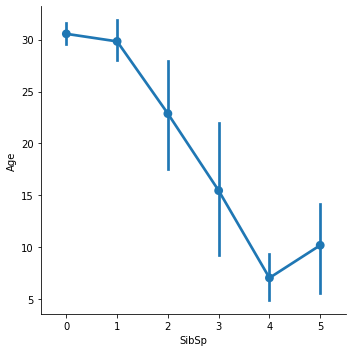

In [29]:
# osserviamo altri tipi di realazione con l'età:
# età e numero di parenti/figli: si noti come, all'aumentare dell'età (eccetto un certo numero di individui intorno ai 30 anni), è più probabile che si trovino passeggeri con genitori e uno o più figli a bordo
# i passeggeri più giovani (sotto i 20 anni) si fermano ad un valore di due, da intendersi, probabilmente, solo come i loro genitori  

sns.factorplot(y='Age',x='Parch', kind='point', data=train)

# età e numero di fratelli/sorelle/coniugi: i passeggeri più giovani presentano il maggior numero di fratelli e sorelle a bordo, mentre più si avanza con l'età minore è il numero.
# probabilmente diversi passeggeri viaggiavano in coppia solo col proprio coniuge

sns.factorplot(y='Age',x='SibSp', kind='point', data=train)

In [30]:
#Di interesse è anche la relazione tra dimensione del gruppo famigliare e sopravvivenza

print(train[['FamSize','Survived']].groupby('FamSize', as_index=False).mean().sort_values(by = 'Survived', ascending=False))

   FamSize  Survived
3        4  0.724138
2        3  0.578431
1        2  0.552795
6        7  0.333333
0        1  0.303538
4        5  0.200000
5        6  0.052632
7        8  0.000000


In [31]:
print(train[['Alone','Survived']].groupby('Alone', as_index=False).mean().sort_values(by = 'Survived', ascending=False))

# è più probabile che chi stesse viaggiando da solo si sia salvato rispetto a chi viaggiava in famiglia.
# in più, la sopravvivenza è bassa nelle famiglie numerose

   Alone  Survived
0      0  0.514535
1      1  0.303538


<AxesSubplot:>

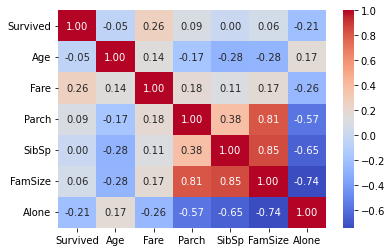

In [32]:
# provo ora a vedere la correlazione tra le variabili numeriche e la variabile di sopravvivenza

sns.heatmap(train[['Survived','Age','Fare','Parch','SibSp','FamSize','Alone']].corr(), annot=True, fmt='.2f', cmap='coolwarm')

# l'unica che mostra un valore significante è Fare. Come già visto, le tariffe più alte erano legate ai posti in prima classe, i quali hanno visto più sopravvissuti

C:\Users\loren\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


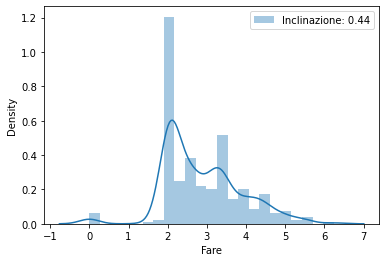

In [33]:
# un'ultima operazione prima dell'applicaizone dei modelli statistici: vista la forte inclinazione a sx della variabile Fare, è opportuna apportare una trasformazione logaritmica per renderla più normale.
# distribuzioni fortemente polarizzate possono inquinare le analisi

train['Fare'] = train['Fare'].map(lambda x: np.log(x) if x > 0 else 0)

sns.distplot(train['Fare'], label = 'Inclinazione: %.2f'%(train['Fare'].skew()))
plt.legend(loc='best')

C:\Users\loren\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


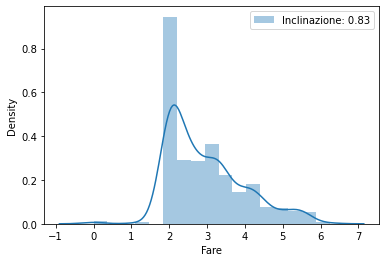

In [34]:
# ripeto per il dataset di test

test['Fare'] = test['Fare'].map(lambda x: np.log(x) if x > 0 else 0)

sns.distplot(test['Fare'], label = 'Inclinazione: %.2f'%(test['Fare'].skew()))
plt.legend(loc='best')

In [35]:
# MODELLI:

# Ho deciso di applicare logistic regression, support vector machine, KNN, random forest e boosting 

# innanzitutto split del train dataset. Assegno i valori di GenderSubmission com y_test, mentre 

x_train=train.drop(['Survived'], axis=1)
y_train=train['Survived']
x_test=test.copy()
y_test=gs['Survived']

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)

x_train (881, 12)
y_train (881,)
x_test (418, 12)
y_test (418,)


In [36]:
# Le variabili misurate su scale diverse potrebbero creare un bias, perciò è bene normalizzarle
# uno strumento adatto è la funzione MinMax (tutte le variabili scalate con calori da 0 a 1)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [37]:
# Logistic Regression

logit = LogisticRegression()
logit.fit(x_train,y_train)
logit_pred = logit.predict(x_test)

In [38]:
print(classification_report(y_test,logit_pred))
print(confusion_matrix(y_test,logit_pred))

# la regressione logistica ottiene il 95% di accuratezza nella previsione dei dati di test.
# La confusion matrix segna che gli errori si registrano perlopiù nei "falsi positivi", ovvero passeggeri predetti come sopravvissuti ma in realtà morti

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       266
           1       0.91      0.96      0.93       152

    accuracy                           0.95       418
   macro avg       0.94      0.95      0.95       418
weighted avg       0.95      0.95      0.95       418

[[251  15]
 [  6 146]]


In [39]:
# Support Vector Machine

# inizio con un hyperparameter tuning per SVM, in modo da evitare che il modello overfitti i dati

param_grid = {'C': [0.1, 1, 10, 50, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001],
              'kernel': ['rbf']}
 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
 
# fit del modello per trovare i parametri migliori

grid.fit(x_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.808 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.807 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.807 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.790 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.818 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.802 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.807 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.784 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.750 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.795 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.616 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 2/5] END ......C=50, gamma=0.01, kernel=rbf;, score=0.807 total time=   0.0s
[CV 3/5] END ......C=50, gamma=0.01, kernel=rbf;, score=0.784 total time=   0.0s
[CV 4/5] END ......C=50, gamma=0.01, kernel=rbf;, score=0.750 total time=   0.0s
[CV 5/5] END ......C=50, gamma=0.01, kernel=rbf;, score=0.795 total time=   0.0s
[CV 1/5] END .....C=50, gamma=0.001, kernel=rbf;, score=0.802 total time=   0.0s
[CV 2/5] END .....C=50, gamma=0.001, kernel=rbf;, score=0.807 total time=   0.0s
[CV 3/5] END .....C=50, gamma=0.001, kernel=rbf;, score=0.784 total time=   0.0s
[CV 4/5] END .....C=50, gamma=0.001, kernel=rbf;, score=0.750 total time=   0.0s
[CV 5/5] END .....C=50, gamma=0.001, kernel=rbf;, score=0.795 total time=   0.0s
[CV 1/5] END ....C=50, gamma=0.0001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 2/5] END ....C=50, gamma=0.0001, kernel=rbf;, score=0.807 total time=   0.0s
[CV 3/5] END ....C=50, gamma=0.0001, kernel=rbf;, score=0.784 total time=   0.0s
[CV 4/5] END ....C=50, gamma

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 50, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05],
                         'kernel': ['rbf']},
             verbose=3)

In [40]:
# miglior parametro
print(grid.best_params_)
 
# modello post scelta del parametro
print(grid.best_estimator_)

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=10, gamma=1)


In [41]:
svm = SVC(C = 10, gamma = 1, kernel = 'rbf')
svm.fit(x_train, y_train)
svm_pred = svm.predict(x_test)
          
# print classification report
print(classification_report(y_test, svm_pred))
print(confusion_matrix(y_test,svm_pred))

# questo modello ha un'accuratezza inferiore della regressione logistica, ovvero 80%. Procedo con gli altri

              precision    recall  f1-score   support

           0       0.85      0.84      0.84       266
           1       0.73      0.73      0.73       152

    accuracy                           0.80       418
   macro avg       0.79      0.79      0.79       418
weighted avg       0.80      0.80      0.80       418

[[224  42]
 [ 41 111]]


In [42]:
# KNN

# innanzitutto creo un loop per trovare il giusto numero di K

error_list = []

for i in range(1,300):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(x_train,y_train)
    knn_pred = knn.predict(x_test)
    error_list.append(np.mean(knn_pred != y_test))


18

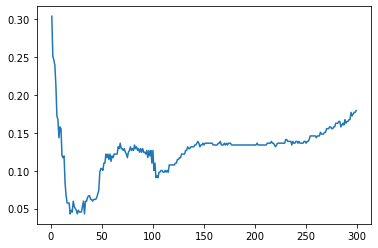

In [43]:
plt.plot(range(1,300), error_list)

np.argmin(error_list)

# Il numero di K ottimale per minimizzare l'errore è 18, tuttavia un numero dispari è preferibile, inserisco 19. 

In [44]:
knn = KNeighborsClassifier(n_neighbors = 19)
knn.fit(x_train,y_train)
knn_pred = knn.predict(x_test)

print(classification_report(y_test,knn_pred))
print(confusion_matrix(y_test,knn_pred))

# il KNN ha performato ancora meglio della regressione logistica con un 96% di accuratezza

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       266
           1       0.95      0.93      0.94       152

    accuracy                           0.96       418
   macro avg       0.96      0.95      0.95       418
weighted avg       0.96      0.96      0.96       418

[[259   7]
 [ 11 141]]


In [45]:
# Random forest e decision tree

dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()

dtc.fit(x_train, y_train)
rfc.fit(x_train, y_train)

dtc_pred = dtc.predict(x_test)
rfc_pred = rfc.predict(x_test)

In [46]:
print(classification_report(y_test,dtc_pred))
print(confusion_matrix(y_test,dtc_pred))

              precision    recall  f1-score   support

           0       0.78      0.79      0.79       266
           1       0.63      0.62      0.62       152

    accuracy                           0.73       418
   macro avg       0.71      0.71      0.71       418
weighted avg       0.73      0.73      0.73       418

[[211  55]
 [ 58  94]]


In [47]:
print(classification_report(y_test,rfc_pred))
print(confusion_matrix(y_test,rfc_pred))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       266
           1       0.75      0.69      0.72       152

    accuracy                           0.80       418
   macro avg       0.79      0.78      0.78       418
weighted avg       0.80      0.80      0.80       418

[[231  35]
 [ 47 105]]


In [48]:
# i modelli con decision tree e random forest performano ancora peggio del SVM, con 71% e 78% di accuratezza rispettivamente

In [49]:
# Boosting

boost = CatBoostClassifier()
boost.fit(x_train, y_train)
boost_pred = boost.predict(x_test)

Learning rate set to 0.00976
0:	learn: 0.6875712	total: 155ms	remaining: 2m 34s
1:	learn: 0.6817023	total: 159ms	remaining: 1m 19s
2:	learn: 0.6758012	total: 163ms	remaining: 54.2s
3:	learn: 0.6699965	total: 168ms	remaining: 41.7s
4:	learn: 0.6643346	total: 172ms	remaining: 34.3s
5:	learn: 0.6587104	total: 176ms	remaining: 29.2s
6:	learn: 0.6529961	total: 180ms	remaining: 25.6s
7:	learn: 0.6490941	total: 185ms	remaining: 22.9s
8:	learn: 0.6441233	total: 189ms	remaining: 20.8s
9:	learn: 0.6392616	total: 194ms	remaining: 19.3s
10:	learn: 0.6337165	total: 199ms	remaining: 17.9s
11:	learn: 0.6279080	total: 203ms	remaining: 16.7s
12:	learn: 0.6240244	total: 206ms	remaining: 15.6s
13:	learn: 0.6186894	total: 210ms	remaining: 14.8s
14:	learn: 0.6138778	total: 214ms	remaining: 14s
15:	learn: 0.6090851	total: 218ms	remaining: 13.4s
16:	learn: 0.6043597	total: 222ms	remaining: 12.8s
17:	learn: 0.5993621	total: 226ms	remaining: 12.3s
18:	learn: 0.5952440	total: 230ms	remaining: 11.9s
19:	learn: 0

180:	learn: 0.3790865	total: 853ms	remaining: 3.86s
181:	learn: 0.3787271	total: 857ms	remaining: 3.85s
182:	learn: 0.3782693	total: 860ms	remaining: 3.84s
183:	learn: 0.3781177	total: 862ms	remaining: 3.82s
184:	learn: 0.3776879	total: 882ms	remaining: 3.88s
185:	learn: 0.3771854	total: 884ms	remaining: 3.87s
186:	learn: 0.3768209	total: 887ms	remaining: 3.85s
187:	learn: 0.3762897	total: 890ms	remaining: 3.84s
188:	learn: 0.3758800	total: 893ms	remaining: 3.83s
189:	learn: 0.3754506	total: 895ms	remaining: 3.82s
190:	learn: 0.3750879	total: 899ms	remaining: 3.81s
191:	learn: 0.3746980	total: 902ms	remaining: 3.8s
192:	learn: 0.3744511	total: 905ms	remaining: 3.78s
193:	learn: 0.3741851	total: 907ms	remaining: 3.77s
194:	learn: 0.3736483	total: 911ms	remaining: 3.76s
195:	learn: 0.3733447	total: 914ms	remaining: 3.75s
196:	learn: 0.3729807	total: 918ms	remaining: 3.74s
197:	learn: 0.3726533	total: 921ms	remaining: 3.73s
198:	learn: 0.3723379	total: 923ms	remaining: 3.72s
199:	learn: 0

339:	learn: 0.3405750	total: 1.41s	remaining: 2.73s
340:	learn: 0.3404437	total: 1.41s	remaining: 2.73s
341:	learn: 0.3402747	total: 1.42s	remaining: 2.72s
342:	learn: 0.3401032	total: 1.42s	remaining: 2.72s
343:	learn: 0.3399005	total: 1.42s	remaining: 2.71s
344:	learn: 0.3396990	total: 1.43s	remaining: 2.71s
345:	learn: 0.3394108	total: 1.43s	remaining: 2.71s
346:	learn: 0.3392053	total: 1.44s	remaining: 2.7s
347:	learn: 0.3389926	total: 1.44s	remaining: 2.7s
348:	learn: 0.3388354	total: 1.44s	remaining: 2.69s
349:	learn: 0.3387175	total: 1.45s	remaining: 2.69s
350:	learn: 0.3386115	total: 1.45s	remaining: 2.68s
351:	learn: 0.3385306	total: 1.46s	remaining: 2.68s
352:	learn: 0.3381713	total: 1.46s	remaining: 2.68s
353:	learn: 0.3381597	total: 1.46s	remaining: 2.67s
354:	learn: 0.3379096	total: 1.47s	remaining: 2.66s
355:	learn: 0.3377005	total: 1.47s	remaining: 2.66s
356:	learn: 0.3375315	total: 1.47s	remaining: 2.65s
357:	learn: 0.3373853	total: 1.48s	remaining: 2.65s
358:	learn: 0.

511:	learn: 0.3145704	total: 2.07s	remaining: 1.97s
512:	learn: 0.3144928	total: 2.07s	remaining: 1.97s
513:	learn: 0.3141212	total: 2.08s	remaining: 1.96s
514:	learn: 0.3140145	total: 2.08s	remaining: 1.96s
515:	learn: 0.3139515	total: 2.08s	remaining: 1.96s
516:	learn: 0.3138817	total: 2.09s	remaining: 1.95s
517:	learn: 0.3137834	total: 2.09s	remaining: 1.95s
518:	learn: 0.3135139	total: 2.1s	remaining: 1.94s
519:	learn: 0.3132655	total: 2.1s	remaining: 1.94s
520:	learn: 0.3132625	total: 2.1s	remaining: 1.93s
521:	learn: 0.3130809	total: 2.11s	remaining: 1.93s
522:	learn: 0.3129638	total: 2.11s	remaining: 1.92s
523:	learn: 0.3128546	total: 2.11s	remaining: 1.92s
524:	learn: 0.3126723	total: 2.12s	remaining: 1.91s
525:	learn: 0.3125750	total: 2.12s	remaining: 1.91s
526:	learn: 0.3125138	total: 2.12s	remaining: 1.91s
527:	learn: 0.3123242	total: 2.13s	remaining: 1.9s
528:	learn: 0.3122291	total: 2.13s	remaining: 1.9s
529:	learn: 0.3121100	total: 2.14s	remaining: 1.89s
530:	learn: 0.311

691:	learn: 0.2911926	total: 2.77s	remaining: 1.23s
692:	learn: 0.2909347	total: 2.77s	remaining: 1.23s
693:	learn: 0.2908055	total: 2.77s	remaining: 1.22s
694:	learn: 0.2906281	total: 2.78s	remaining: 1.22s
695:	learn: 0.2905351	total: 2.78s	remaining: 1.22s
696:	learn: 0.2904315	total: 2.79s	remaining: 1.21s
697:	learn: 0.2903535	total: 2.79s	remaining: 1.21s
698:	learn: 0.2901759	total: 2.8s	remaining: 1.2s
699:	learn: 0.2898499	total: 2.8s	remaining: 1.2s
700:	learn: 0.2898155	total: 2.8s	remaining: 1.2s
701:	learn: 0.2897497	total: 2.81s	remaining: 1.19s
702:	learn: 0.2896960	total: 2.81s	remaining: 1.19s
703:	learn: 0.2896126	total: 2.81s	remaining: 1.18s
704:	learn: 0.2894755	total: 2.82s	remaining: 1.18s
705:	learn: 0.2893452	total: 2.82s	remaining: 1.18s
706:	learn: 0.2890967	total: 2.83s	remaining: 1.17s
707:	learn: 0.2889591	total: 2.83s	remaining: 1.17s
708:	learn: 0.2888138	total: 2.84s	remaining: 1.16s
709:	learn: 0.2885917	total: 2.84s	remaining: 1.16s
710:	learn: 0.2884

866:	learn: 0.2684393	total: 3.46s	remaining: 532ms
867:	learn: 0.2683795	total: 3.47s	remaining: 528ms
868:	learn: 0.2682422	total: 3.47s	remaining: 524ms
869:	learn: 0.2679870	total: 3.48s	remaining: 520ms
870:	learn: 0.2678330	total: 3.48s	remaining: 516ms
871:	learn: 0.2677483	total: 3.48s	remaining: 512ms
872:	learn: 0.2676960	total: 3.49s	remaining: 508ms
873:	learn: 0.2675774	total: 3.49s	remaining: 504ms
874:	learn: 0.2674104	total: 3.5s	remaining: 500ms
875:	learn: 0.2672951	total: 3.5s	remaining: 496ms
876:	learn: 0.2672332	total: 3.5s	remaining: 492ms
877:	learn: 0.2670894	total: 3.51s	remaining: 488ms
878:	learn: 0.2669745	total: 3.51s	remaining: 484ms
879:	learn: 0.2668792	total: 3.52s	remaining: 480ms
880:	learn: 0.2667315	total: 3.52s	remaining: 476ms
881:	learn: 0.2665793	total: 3.52s	remaining: 472ms
882:	learn: 0.2664892	total: 3.53s	remaining: 468ms
883:	learn: 0.2664643	total: 3.53s	remaining: 464ms
884:	learn: 0.2663624	total: 3.54s	remaining: 460ms
885:	learn: 0.2

In [50]:
print(classification_report(y_test,boost_pred))
print(confusion_matrix(y_test,boost_pred))

# questo performa in maniera leggermente migliore ai precedenti, con 83% di accuratezza

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       266
           1       0.80      0.71      0.75       152

    accuracy                           0.83       418
   macro avg       0.82      0.80      0.81       418
weighted avg       0.83      0.83      0.83       418

[[239  27]
 [ 44 108]]


In [51]:
# sembra che i due modelli più adatti per questo tipo di analisi sia la regressione logistica e il KNN

In [52]:
# Cross validation

# come ultima analisi, serve per stimare come il modello si comporterà, generalmente, quando viene utilizzato per fare previsioni su dati non di training.
# la userò per verificare l'attendibilità nell'accuratezza dei modelli

classifiers=[]

classifiers.append(LogisticRegression())
classifiers.append(DecisionTreeClassifier())
classifiers.append(RandomForestClassifier())
classifiers.append(SVC(C = 10, gamma = 1, kernel = 'rbf'))
classifiers.append(KNeighborsClassifier(n_neighbors=19))
classifiers.append(CatBoostClassifier())

len(classifiers)

6

In [53]:
cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, x_train, y_train, scoring='accuracy',cv=6))

Learning rate set to 0.009028
0:	learn: 0.6868609	total: 4.4ms	remaining: 4.4s
1:	learn: 0.6814046	total: 9.06ms	remaining: 4.52s
2:	learn: 0.6749579	total: 13.2ms	remaining: 4.39s
3:	learn: 0.6683924	total: 17.4ms	remaining: 4.34s
4:	learn: 0.6620671	total: 21.7ms	remaining: 4.31s
5:	learn: 0.6561453	total: 25.7ms	remaining: 4.26s
6:	learn: 0.6507691	total: 29.8ms	remaining: 4.22s
7:	learn: 0.6456298	total: 33.9ms	remaining: 4.21s
8:	learn: 0.6396011	total: 38.2ms	remaining: 4.2s
9:	learn: 0.6351949	total: 42ms	remaining: 4.16s
10:	learn: 0.6302265	total: 45.8ms	remaining: 4.12s
11:	learn: 0.6256257	total: 49.6ms	remaining: 4.08s
12:	learn: 0.6206043	total: 53.6ms	remaining: 4.07s
13:	learn: 0.6160913	total: 57.6ms	remaining: 4.05s
14:	learn: 0.6120704	total: 61.3ms	remaining: 4.03s
15:	learn: 0.6077709	total: 64.2ms	remaining: 3.95s
16:	learn: 0.6025815	total: 67.9ms	remaining: 3.92s
17:	learn: 0.5982234	total: 71.8ms	remaining: 3.92s
18:	learn: 0.5939417	total: 75.5ms	remaining: 3.9

178:	learn: 0.3731261	total: 682ms	remaining: 3.13s
179:	learn: 0.3727696	total: 686ms	remaining: 3.12s
180:	learn: 0.3721962	total: 689ms	remaining: 3.12s
181:	learn: 0.3718943	total: 692ms	remaining: 3.11s
182:	learn: 0.3715134	total: 695ms	remaining: 3.1s
183:	learn: 0.3713063	total: 698ms	remaining: 3.09s
184:	learn: 0.3709417	total: 702ms	remaining: 3.09s
185:	learn: 0.3704772	total: 705ms	remaining: 3.09s
186:	learn: 0.3700967	total: 708ms	remaining: 3.08s
187:	learn: 0.3698894	total: 709ms	remaining: 3.06s
188:	learn: 0.3694531	total: 711ms	remaining: 3.05s
189:	learn: 0.3692549	total: 715ms	remaining: 3.05s
190:	learn: 0.3688748	total: 718ms	remaining: 3.04s
191:	learn: 0.3686513	total: 722ms	remaining: 3.04s
192:	learn: 0.3682434	total: 726ms	remaining: 3.03s
193:	learn: 0.3680576	total: 729ms	remaining: 3.03s
194:	learn: 0.3677413	total: 733ms	remaining: 3.03s
195:	learn: 0.3672855	total: 736ms	remaining: 3.02s
196:	learn: 0.3671174	total: 740ms	remaining: 3.02s
197:	learn: 0

380:	learn: 0.3241002	total: 1.38s	remaining: 2.24s
381:	learn: 0.3240495	total: 1.38s	remaining: 2.23s
382:	learn: 0.3238897	total: 1.38s	remaining: 2.23s
383:	learn: 0.3236974	total: 1.38s	remaining: 2.22s
384:	learn: 0.3234039	total: 1.39s	remaining: 2.21s
385:	learn: 0.3232842	total: 1.39s	remaining: 2.21s
386:	learn: 0.3231683	total: 1.39s	remaining: 2.2s
387:	learn: 0.3231172	total: 1.39s	remaining: 2.2s
388:	learn: 0.3230249	total: 1.4s	remaining: 2.19s
389:	learn: 0.3229822	total: 1.4s	remaining: 2.19s
390:	learn: 0.3227968	total: 1.4s	remaining: 2.19s
391:	learn: 0.3226415	total: 1.41s	remaining: 2.18s
392:	learn: 0.3225275	total: 1.41s	remaining: 2.18s
393:	learn: 0.3224218	total: 1.41s	remaining: 2.17s
394:	learn: 0.3220321	total: 1.41s	remaining: 2.17s
395:	learn: 0.3217986	total: 1.42s	remaining: 2.16s
396:	learn: 0.3216080	total: 1.42s	remaining: 2.16s
397:	learn: 0.3213808	total: 1.43s	remaining: 2.15s
398:	learn: 0.3211614	total: 1.43s	remaining: 2.15s
399:	learn: 0.321

588:	learn: 0.2932155	total: 2.07s	remaining: 1.45s
589:	learn: 0.2930616	total: 2.08s	remaining: 1.44s
590:	learn: 0.2930008	total: 2.08s	remaining: 1.44s
591:	learn: 0.2929392	total: 2.08s	remaining: 1.44s
592:	learn: 0.2928605	total: 2.09s	remaining: 1.43s
593:	learn: 0.2927109	total: 2.09s	remaining: 1.43s
594:	learn: 0.2924988	total: 2.09s	remaining: 1.42s
595:	learn: 0.2923233	total: 2.09s	remaining: 1.42s
596:	learn: 0.2922087	total: 2.1s	remaining: 1.42s
597:	learn: 0.2920713	total: 2.1s	remaining: 1.41s
598:	learn: 0.2919948	total: 2.1s	remaining: 1.41s
599:	learn: 0.2918262	total: 2.11s	remaining: 1.41s
600:	learn: 0.2917482	total: 2.11s	remaining: 1.4s
601:	learn: 0.2916627	total: 2.11s	remaining: 1.4s
602:	learn: 0.2913910	total: 2.12s	remaining: 1.39s
603:	learn: 0.2913300	total: 2.12s	remaining: 1.39s
604:	learn: 0.2912294	total: 2.12s	remaining: 1.39s
605:	learn: 0.2911140	total: 2.13s	remaining: 1.38s
606:	learn: 0.2910674	total: 2.13s	remaining: 1.38s
607:	learn: 0.290

748:	learn: 0.2730687	total: 2.6s	remaining: 870ms
749:	learn: 0.2730258	total: 2.6s	remaining: 866ms
750:	learn: 0.2728949	total: 2.6s	remaining: 863ms
751:	learn: 0.2726856	total: 2.61s	remaining: 860ms
752:	learn: 0.2724947	total: 2.61s	remaining: 856ms
753:	learn: 0.2724878	total: 2.61s	remaining: 851ms
754:	learn: 0.2724399	total: 2.61s	remaining: 848ms
755:	learn: 0.2724166	total: 2.62s	remaining: 844ms
756:	learn: 0.2721612	total: 2.62s	remaining: 841ms
757:	learn: 0.2720353	total: 2.62s	remaining: 837ms
758:	learn: 0.2716340	total: 2.63s	remaining: 834ms
759:	learn: 0.2714396	total: 2.63s	remaining: 830ms
760:	learn: 0.2712432	total: 2.63s	remaining: 827ms
761:	learn: 0.2711698	total: 2.64s	remaining: 824ms
762:	learn: 0.2710333	total: 2.64s	remaining: 820ms
763:	learn: 0.2709378	total: 2.64s	remaining: 817ms
764:	learn: 0.2709132	total: 2.65s	remaining: 813ms
765:	learn: 0.2707354	total: 2.65s	remaining: 810ms
766:	learn: 0.2705871	total: 2.65s	remaining: 807ms
767:	learn: 0.2

932:	learn: 0.2480225	total: 3.29s	remaining: 236ms
933:	learn: 0.2478289	total: 3.29s	remaining: 233ms
934:	learn: 0.2476653	total: 3.3s	remaining: 229ms
935:	learn: 0.2475009	total: 3.3s	remaining: 226ms
936:	learn: 0.2474358	total: 3.3s	remaining: 222ms
937:	learn: 0.2473630	total: 3.31s	remaining: 219ms
938:	learn: 0.2472742	total: 3.31s	remaining: 215ms
939:	learn: 0.2472181	total: 3.32s	remaining: 212ms
940:	learn: 0.2469475	total: 3.32s	remaining: 208ms
941:	learn: 0.2468800	total: 3.32s	remaining: 205ms
942:	learn: 0.2467189	total: 3.33s	remaining: 201ms
943:	learn: 0.2465575	total: 3.33s	remaining: 198ms
944:	learn: 0.2463404	total: 3.33s	remaining: 194ms
945:	learn: 0.2461020	total: 3.34s	remaining: 191ms
946:	learn: 0.2458760	total: 3.34s	remaining: 187ms
947:	learn: 0.2457504	total: 3.35s	remaining: 184ms
948:	learn: 0.2455673	total: 3.35s	remaining: 180ms
949:	learn: 0.2453541	total: 3.35s	remaining: 176ms
950:	learn: 0.2451958	total: 3.36s	remaining: 173ms
951:	learn: 0.2

96:	learn: 0.4245856	total: 375ms	remaining: 3.49s
97:	learn: 0.4238110	total: 378ms	remaining: 3.48s
98:	learn: 0.4228789	total: 380ms	remaining: 3.46s
99:	learn: 0.4217751	total: 384ms	remaining: 3.46s
100:	learn: 0.4208483	total: 388ms	remaining: 3.45s
101:	learn: 0.4196894	total: 391ms	remaining: 3.44s
102:	learn: 0.4183295	total: 394ms	remaining: 3.43s
103:	learn: 0.4174434	total: 398ms	remaining: 3.43s
104:	learn: 0.4162089	total: 401ms	remaining: 3.42s
105:	learn: 0.4153543	total: 405ms	remaining: 3.42s
106:	learn: 0.4141876	total: 409ms	remaining: 3.41s
107:	learn: 0.4130651	total: 412ms	remaining: 3.4s
108:	learn: 0.4119491	total: 416ms	remaining: 3.4s
109:	learn: 0.4107316	total: 419ms	remaining: 3.39s
110:	learn: 0.4099649	total: 423ms	remaining: 3.39s
111:	learn: 0.4093739	total: 426ms	remaining: 3.38s
112:	learn: 0.4082224	total: 430ms	remaining: 3.38s
113:	learn: 0.4075544	total: 434ms	remaining: 3.37s
114:	learn: 0.4066641	total: 438ms	remaining: 3.37s
115:	learn: 0.4059

278:	learn: 0.3372364	total: 1.07s	remaining: 2.76s
279:	learn: 0.3370358	total: 1.07s	remaining: 2.76s
280:	learn: 0.3367184	total: 1.08s	remaining: 2.75s
281:	learn: 0.3364532	total: 1.08s	remaining: 2.75s
282:	learn: 0.3362959	total: 1.08s	remaining: 2.75s
283:	learn: 0.3360922	total: 1.09s	remaining: 2.74s
284:	learn: 0.3357725	total: 1.09s	remaining: 2.73s
285:	learn: 0.3355683	total: 1.09s	remaining: 2.73s
286:	learn: 0.3352826	total: 1.1s	remaining: 2.73s
287:	learn: 0.3349402	total: 1.1s	remaining: 2.72s
288:	learn: 0.3347147	total: 1.11s	remaining: 2.72s
289:	learn: 0.3344121	total: 1.11s	remaining: 2.72s
290:	learn: 0.3339589	total: 1.11s	remaining: 2.71s
291:	learn: 0.3337210	total: 1.12s	remaining: 2.71s
292:	learn: 0.3336178	total: 1.12s	remaining: 2.71s
293:	learn: 0.3332689	total: 1.13s	remaining: 2.7s
294:	learn: 0.3328397	total: 1.13s	remaining: 2.7s
295:	learn: 0.3326453	total: 1.13s	remaining: 2.7s
296:	learn: 0.3324228	total: 1.15s	remaining: 2.71s
297:	learn: 0.332

470:	learn: 0.2986051	total: 1.76s	remaining: 1.98s
471:	learn: 0.2984793	total: 1.77s	remaining: 1.98s
472:	learn: 0.2983476	total: 1.77s	remaining: 1.97s
473:	learn: 0.2980993	total: 1.77s	remaining: 1.97s
474:	learn: 0.2978946	total: 1.78s	remaining: 1.96s
475:	learn: 0.2977607	total: 1.78s	remaining: 1.96s
476:	learn: 0.2976370	total: 1.78s	remaining: 1.96s
477:	learn: 0.2974562	total: 1.79s	remaining: 1.95s
478:	learn: 0.2973427	total: 1.79s	remaining: 1.95s
479:	learn: 0.2972485	total: 1.8s	remaining: 1.95s
480:	learn: 0.2971687	total: 1.8s	remaining: 1.94s
481:	learn: 0.2969553	total: 1.8s	remaining: 1.94s
482:	learn: 0.2966712	total: 1.8s	remaining: 1.93s
483:	learn: 0.2964205	total: 1.81s	remaining: 1.93s
484:	learn: 0.2963704	total: 1.81s	remaining: 1.92s
485:	learn: 0.2963670	total: 1.81s	remaining: 1.92s
486:	learn: 0.2962958	total: 1.82s	remaining: 1.91s
487:	learn: 0.2960794	total: 1.82s	remaining: 1.91s
488:	learn: 0.2959194	total: 1.82s	remaining: 1.91s
489:	learn: 0.29

657:	learn: 0.2713566	total: 2.46s	remaining: 1.28s
658:	learn: 0.2712230	total: 2.46s	remaining: 1.27s
659:	learn: 0.2711054	total: 2.46s	remaining: 1.27s
660:	learn: 0.2710122	total: 2.47s	remaining: 1.27s
661:	learn: 0.2709366	total: 2.47s	remaining: 1.26s
662:	learn: 0.2708291	total: 2.48s	remaining: 1.26s
663:	learn: 0.2706443	total: 2.48s	remaining: 1.25s
664:	learn: 0.2706420	total: 2.48s	remaining: 1.25s
665:	learn: 0.2705388	total: 2.49s	remaining: 1.25s
666:	learn: 0.2702940	total: 2.49s	remaining: 1.24s
667:	learn: 0.2702867	total: 2.49s	remaining: 1.24s
668:	learn: 0.2701872	total: 2.5s	remaining: 1.23s
669:	learn: 0.2700990	total: 2.5s	remaining: 1.23s
670:	learn: 0.2700788	total: 2.5s	remaining: 1.23s
671:	learn: 0.2699755	total: 2.51s	remaining: 1.22s
672:	learn: 0.2698213	total: 2.51s	remaining: 1.22s
673:	learn: 0.2697309	total: 2.51s	remaining: 1.22s
674:	learn: 0.2695823	total: 2.52s	remaining: 1.21s
675:	learn: 0.2695234	total: 2.52s	remaining: 1.21s
676:	learn: 0.2

843:	learn: 0.2468370	total: 3.15s	remaining: 582ms
844:	learn: 0.2466901	total: 3.15s	remaining: 579ms
845:	learn: 0.2465793	total: 3.16s	remaining: 575ms
846:	learn: 0.2464364	total: 3.16s	remaining: 571ms
847:	learn: 0.2462489	total: 3.16s	remaining: 567ms
848:	learn: 0.2460801	total: 3.17s	remaining: 563ms
849:	learn: 0.2460277	total: 3.17s	remaining: 560ms
850:	learn: 0.2459264	total: 3.17s	remaining: 556ms
851:	learn: 0.2458895	total: 3.18s	remaining: 552ms
852:	learn: 0.2456987	total: 3.18s	remaining: 548ms
853:	learn: 0.2456125	total: 3.19s	remaining: 545ms
854:	learn: 0.2453062	total: 3.19s	remaining: 541ms
855:	learn: 0.2452200	total: 3.19s	remaining: 537ms
856:	learn: 0.2449816	total: 3.2s	remaining: 534ms
857:	learn: 0.2448072	total: 3.2s	remaining: 530ms
858:	learn: 0.2445758	total: 3.21s	remaining: 526ms
859:	learn: 0.2443711	total: 3.21s	remaining: 522ms
860:	learn: 0.2442793	total: 3.21s	remaining: 519ms
861:	learn: 0.2441084	total: 3.22s	remaining: 515ms
862:	learn: 0.

49:	learn: 0.5148758	total: 184ms	remaining: 3.5s
50:	learn: 0.5124667	total: 188ms	remaining: 3.5s
51:	learn: 0.5101835	total: 192ms	remaining: 3.5s
52:	learn: 0.5084709	total: 196ms	remaining: 3.49s
53:	learn: 0.5064727	total: 199ms	remaining: 3.49s
54:	learn: 0.5037653	total: 203ms	remaining: 3.48s
55:	learn: 0.5019696	total: 207ms	remaining: 3.48s
56:	learn: 0.4995478	total: 211ms	remaining: 3.49s
57:	learn: 0.4977900	total: 214ms	remaining: 3.48s
58:	learn: 0.4956645	total: 218ms	remaining: 3.47s
59:	learn: 0.4939812	total: 222ms	remaining: 3.47s
60:	learn: 0.4923370	total: 225ms	remaining: 3.47s
61:	learn: 0.4909883	total: 229ms	remaining: 3.47s
62:	learn: 0.4894146	total: 232ms	remaining: 3.45s
63:	learn: 0.4874360	total: 236ms	remaining: 3.45s
64:	learn: 0.4858484	total: 239ms	remaining: 3.44s
65:	learn: 0.4843645	total: 242ms	remaining: 3.42s
66:	learn: 0.4826937	total: 246ms	remaining: 3.42s
67:	learn: 0.4808980	total: 249ms	remaining: 3.42s
68:	learn: 0.4789857	total: 253ms	

238:	learn: 0.3703665	total: 879ms	remaining: 2.8s
239:	learn: 0.3699231	total: 882ms	remaining: 2.79s
240:	learn: 0.3697245	total: 884ms	remaining: 2.78s
241:	learn: 0.3691438	total: 888ms	remaining: 2.78s
242:	learn: 0.3688274	total: 890ms	remaining: 2.77s
243:	learn: 0.3686271	total: 892ms	remaining: 2.76s
244:	learn: 0.3683352	total: 896ms	remaining: 2.76s
245:	learn: 0.3679799	total: 900ms	remaining: 2.76s
246:	learn: 0.3677747	total: 904ms	remaining: 2.76s
247:	learn: 0.3675766	total: 908ms	remaining: 2.75s
248:	learn: 0.3671927	total: 911ms	remaining: 2.75s
249:	learn: 0.3668614	total: 915ms	remaining: 2.75s
250:	learn: 0.3665450	total: 919ms	remaining: 2.74s
251:	learn: 0.3662093	total: 923ms	remaining: 2.74s
252:	learn: 0.3658319	total: 926ms	remaining: 2.73s
253:	learn: 0.3656067	total: 930ms	remaining: 2.73s
254:	learn: 0.3655117	total: 932ms	remaining: 2.72s
255:	learn: 0.3650852	total: 935ms	remaining: 2.72s
256:	learn: 0.3648194	total: 939ms	remaining: 2.72s
257:	learn: 0

427:	learn: 0.3278842	total: 1.57s	remaining: 2.1s
428:	learn: 0.3277500	total: 1.58s	remaining: 2.1s
429:	learn: 0.3275178	total: 1.58s	remaining: 2.1s
430:	learn: 0.3273282	total: 1.58s	remaining: 2.09s
431:	learn: 0.3271221	total: 1.59s	remaining: 2.09s
432:	learn: 0.3268760	total: 1.59s	remaining: 2.08s
433:	learn: 0.3268482	total: 1.59s	remaining: 2.08s
434:	learn: 0.3265975	total: 1.6s	remaining: 2.08s
435:	learn: 0.3265351	total: 1.6s	remaining: 2.07s
436:	learn: 0.3261823	total: 1.6s	remaining: 2.07s
437:	learn: 0.3259854	total: 1.61s	remaining: 2.06s
438:	learn: 0.3257601	total: 1.61s	remaining: 2.06s
439:	learn: 0.3256028	total: 1.62s	remaining: 2.06s
440:	learn: 0.3254055	total: 1.62s	remaining: 2.05s
441:	learn: 0.3252861	total: 1.62s	remaining: 2.05s
442:	learn: 0.3252595	total: 1.63s	remaining: 2.05s
443:	learn: 0.3251196	total: 1.63s	remaining: 2.04s
444:	learn: 0.3250323	total: 1.64s	remaining: 2.04s
445:	learn: 0.3247550	total: 1.64s	remaining: 2.04s
446:	learn: 0.3245

608:	learn: 0.3005375	total: 2.27s	remaining: 1.46s
609:	learn: 0.3004428	total: 2.27s	remaining: 1.45s
610:	learn: 0.3002573	total: 2.28s	remaining: 1.45s
611:	learn: 0.3001229	total: 2.28s	remaining: 1.45s
612:	learn: 0.2999918	total: 2.28s	remaining: 1.44s
613:	learn: 0.2998783	total: 2.29s	remaining: 1.44s
614:	learn: 0.2997768	total: 2.29s	remaining: 1.44s
615:	learn: 0.2997403	total: 2.29s	remaining: 1.43s
616:	learn: 0.2996124	total: 2.3s	remaining: 1.43s
617:	learn: 0.2994081	total: 2.3s	remaining: 1.42s
618:	learn: 0.2993943	total: 2.31s	remaining: 1.42s
619:	learn: 0.2992128	total: 2.31s	remaining: 1.42s
620:	learn: 0.2990787	total: 2.31s	remaining: 1.41s
621:	learn: 0.2990188	total: 2.32s	remaining: 1.41s
622:	learn: 0.2988506	total: 2.32s	remaining: 1.4s
623:	learn: 0.2988131	total: 2.32s	remaining: 1.4s
624:	learn: 0.2986938	total: 2.33s	remaining: 1.4s
625:	learn: 0.2984051	total: 2.33s	remaining: 1.39s
626:	learn: 0.2982411	total: 2.34s	remaining: 1.39s
627:	learn: 0.298

786:	learn: 0.2757369	total: 2.96s	remaining: 802ms
787:	learn: 0.2756704	total: 2.97s	remaining: 798ms
788:	learn: 0.2755940	total: 2.97s	remaining: 795ms
789:	learn: 0.2755525	total: 2.98s	remaining: 791ms
790:	learn: 0.2752562	total: 2.98s	remaining: 787ms
791:	learn: 0.2750714	total: 2.98s	remaining: 783ms
792:	learn: 0.2749848	total: 2.99s	remaining: 780ms
793:	learn: 0.2747273	total: 2.99s	remaining: 776ms
794:	learn: 0.2746285	total: 2.99s	remaining: 772ms
795:	learn: 0.2744983	total: 3s	remaining: 768ms
796:	learn: 0.2743751	total: 3s	remaining: 765ms
797:	learn: 0.2741638	total: 3.01s	remaining: 762ms
798:	learn: 0.2741377	total: 3.01s	remaining: 758ms
799:	learn: 0.2740824	total: 3.02s	remaining: 754ms
800:	learn: 0.2740103	total: 3.02s	remaining: 750ms
801:	learn: 0.2740063	total: 3.02s	remaining: 746ms
802:	learn: 0.2739591	total: 3.02s	remaining: 742ms
803:	learn: 0.2738060	total: 3.03s	remaining: 738ms
804:	learn: 0.2737572	total: 3.03s	remaining: 735ms
805:	learn: 0.2737

963:	learn: 0.2516114	total: 3.66s	remaining: 137ms
964:	learn: 0.2514124	total: 3.66s	remaining: 133ms
965:	learn: 0.2512675	total: 3.66s	remaining: 129ms
966:	learn: 0.2511503	total: 3.67s	remaining: 125ms
967:	learn: 0.2510280	total: 3.67s	remaining: 121ms
968:	learn: 0.2508470	total: 3.67s	remaining: 118ms
969:	learn: 0.2506242	total: 3.68s	remaining: 114ms
970:	learn: 0.2504548	total: 3.68s	remaining: 110ms
971:	learn: 0.2503802	total: 3.69s	remaining: 106ms
972:	learn: 0.2503294	total: 3.69s	remaining: 102ms
973:	learn: 0.2502422	total: 3.69s	remaining: 98.6ms
974:	learn: 0.2500456	total: 3.7s	remaining: 94.8ms
975:	learn: 0.2499605	total: 3.7s	remaining: 91.1ms
976:	learn: 0.2497170	total: 3.71s	remaining: 87.3ms
977:	learn: 0.2494279	total: 3.71s	remaining: 83.5ms
978:	learn: 0.2492692	total: 3.72s	remaining: 79.7ms
979:	learn: 0.2491916	total: 3.72s	remaining: 75.9ms
980:	learn: 0.2490908	total: 3.72s	remaining: 72.1ms
981:	learn: 0.2490280	total: 3.73s	remaining: 68.3ms
982:	

134:	learn: 0.3949986	total: 514ms	remaining: 3.29s
135:	learn: 0.3944538	total: 517ms	remaining: 3.29s
136:	learn: 0.3937232	total: 521ms	remaining: 3.28s
137:	learn: 0.3934296	total: 524ms	remaining: 3.27s
138:	learn: 0.3927313	total: 528ms	remaining: 3.27s
139:	learn: 0.3922446	total: 531ms	remaining: 3.26s
140:	learn: 0.3916808	total: 535ms	remaining: 3.26s
141:	learn: 0.3910092	total: 538ms	remaining: 3.25s
142:	learn: 0.3905583	total: 541ms	remaining: 3.24s
143:	learn: 0.3900781	total: 546ms	remaining: 3.24s
144:	learn: 0.3898876	total: 549ms	remaining: 3.24s
145:	learn: 0.3892623	total: 553ms	remaining: 3.23s
146:	learn: 0.3885625	total: 557ms	remaining: 3.23s
147:	learn: 0.3879685	total: 561ms	remaining: 3.23s
148:	learn: 0.3874741	total: 564ms	remaining: 3.22s
149:	learn: 0.3867801	total: 568ms	remaining: 3.22s
150:	learn: 0.3860125	total: 571ms	remaining: 3.21s
151:	learn: 0.3852808	total: 575ms	remaining: 3.21s
152:	learn: 0.3845844	total: 579ms	remaining: 3.21s
153:	learn: 

311:	learn: 0.3367611	total: 1.2s	remaining: 2.65s
312:	learn: 0.3366160	total: 1.21s	remaining: 2.65s
313:	learn: 0.3364338	total: 1.21s	remaining: 2.64s
314:	learn: 0.3362952	total: 1.21s	remaining: 2.64s
315:	learn: 0.3360487	total: 1.22s	remaining: 2.63s
316:	learn: 0.3357415	total: 1.22s	remaining: 2.63s
317:	learn: 0.3355794	total: 1.23s	remaining: 2.63s
318:	learn: 0.3352669	total: 1.23s	remaining: 2.62s
319:	learn: 0.3349871	total: 1.23s	remaining: 2.62s
320:	learn: 0.3347685	total: 1.24s	remaining: 2.62s
321:	learn: 0.3346113	total: 1.24s	remaining: 2.61s
322:	learn: 0.3343661	total: 1.24s	remaining: 2.61s
323:	learn: 0.3341435	total: 1.25s	remaining: 2.6s
324:	learn: 0.3338393	total: 1.25s	remaining: 2.6s
325:	learn: 0.3335334	total: 1.25s	remaining: 2.6s
326:	learn: 0.3335234	total: 1.26s	remaining: 2.59s
327:	learn: 0.3332787	total: 1.26s	remaining: 2.58s
328:	learn: 0.3330423	total: 1.26s	remaining: 2.58s
329:	learn: 0.3329775	total: 1.27s	remaining: 2.58s
330:	learn: 0.33

504:	learn: 0.3049830	total: 1.9s	remaining: 1.86s
505:	learn: 0.3048208	total: 1.9s	remaining: 1.85s
506:	learn: 0.3046685	total: 1.9s	remaining: 1.85s
507:	learn: 0.3046193	total: 1.91s	remaining: 1.84s
508:	learn: 0.3045309	total: 1.91s	remaining: 1.84s
509:	learn: 0.3043064	total: 1.91s	remaining: 1.84s
510:	learn: 0.3041314	total: 1.92s	remaining: 1.83s
511:	learn: 0.3039372	total: 1.92s	remaining: 1.83s
512:	learn: 0.3037098	total: 1.92s	remaining: 1.82s
513:	learn: 0.3036100	total: 1.93s	remaining: 1.82s
514:	learn: 0.3034435	total: 1.93s	remaining: 1.82s
515:	learn: 0.3031848	total: 1.93s	remaining: 1.81s
516:	learn: 0.3027145	total: 1.94s	remaining: 1.81s
517:	learn: 0.3026321	total: 1.94s	remaining: 1.81s
518:	learn: 0.3025258	total: 1.95s	remaining: 1.8s
519:	learn: 0.3024111	total: 1.95s	remaining: 1.8s
520:	learn: 0.3023272	total: 1.95s	remaining: 1.8s
521:	learn: 0.3022089	total: 1.96s	remaining: 1.79s
522:	learn: 0.3019524	total: 1.96s	remaining: 1.79s
523:	learn: 0.3019

685:	learn: 0.2808031	total: 2.59s	remaining: 1.19s
686:	learn: 0.2804813	total: 2.59s	remaining: 1.18s
687:	learn: 0.2801185	total: 2.6s	remaining: 1.18s
688:	learn: 0.2799364	total: 2.6s	remaining: 1.17s
689:	learn: 0.2796757	total: 2.61s	remaining: 1.17s
690:	learn: 0.2795487	total: 2.61s	remaining: 1.17s
691:	learn: 0.2794823	total: 2.61s	remaining: 1.16s
692:	learn: 0.2792411	total: 2.62s	remaining: 1.16s
693:	learn: 0.2792043	total: 2.62s	remaining: 1.16s
694:	learn: 0.2791347	total: 2.62s	remaining: 1.15s
695:	learn: 0.2788672	total: 2.63s	remaining: 1.15s
696:	learn: 0.2786732	total: 2.63s	remaining: 1.14s
697:	learn: 0.2784776	total: 2.64s	remaining: 1.14s
698:	learn: 0.2783599	total: 2.64s	remaining: 1.14s
699:	learn: 0.2781813	total: 2.64s	remaining: 1.13s
700:	learn: 0.2780837	total: 2.65s	remaining: 1.13s
701:	learn: 0.2779521	total: 2.65s	remaining: 1.13s
702:	learn: 0.2778957	total: 2.65s	remaining: 1.12s
703:	learn: 0.2777411	total: 2.66s	remaining: 1.12s
704:	learn: 0.

861:	learn: 0.2582939	total: 3.28s	remaining: 525ms
862:	learn: 0.2582134	total: 3.29s	remaining: 522ms
863:	learn: 0.2581483	total: 3.29s	remaining: 518ms
864:	learn: 0.2580751	total: 3.29s	remaining: 514ms
865:	learn: 0.2580513	total: 3.3s	remaining: 510ms
866:	learn: 0.2579064	total: 3.3s	remaining: 506ms
867:	learn: 0.2578447	total: 3.3s	remaining: 502ms
868:	learn: 0.2575720	total: 3.31s	remaining: 499ms
869:	learn: 0.2575091	total: 3.31s	remaining: 495ms
870:	learn: 0.2573506	total: 3.31s	remaining: 491ms
871:	learn: 0.2572797	total: 3.32s	remaining: 487ms
872:	learn: 0.2570166	total: 3.32s	remaining: 483ms
873:	learn: 0.2569306	total: 3.33s	remaining: 480ms
874:	learn: 0.2568487	total: 3.33s	remaining: 476ms
875:	learn: 0.2567326	total: 3.33s	remaining: 472ms
876:	learn: 0.2567168	total: 3.34s	remaining: 468ms
877:	learn: 0.2565807	total: 3.34s	remaining: 464ms
878:	learn: 0.2564609	total: 3.34s	remaining: 460ms
879:	learn: 0.2563550	total: 3.35s	remaining: 457ms
880:	learn: 0.2

21:	learn: 0.5931969	total: 85.6ms	remaining: 3.8s
22:	learn: 0.5891261	total: 89.5ms	remaining: 3.8s
23:	learn: 0.5850781	total: 93.3ms	remaining: 3.79s
24:	learn: 0.5812072	total: 97ms	remaining: 3.78s
25:	learn: 0.5774226	total: 101ms	remaining: 3.78s
26:	learn: 0.5735634	total: 105ms	remaining: 3.79s
27:	learn: 0.5702594	total: 109ms	remaining: 3.79s
28:	learn: 0.5683272	total: 111ms	remaining: 3.71s
29:	learn: 0.5651852	total: 115ms	remaining: 3.71s
30:	learn: 0.5615269	total: 119ms	remaining: 3.72s
31:	learn: 0.5583901	total: 123ms	remaining: 3.71s
32:	learn: 0.5548649	total: 127ms	remaining: 3.71s
33:	learn: 0.5517637	total: 131ms	remaining: 3.71s
34:	learn: 0.5483867	total: 135ms	remaining: 3.71s
35:	learn: 0.5457557	total: 138ms	remaining: 3.7s
36:	learn: 0.5427532	total: 142ms	remaining: 3.7s
37:	learn: 0.5403853	total: 146ms	remaining: 3.7s
38:	learn: 0.5388360	total: 148ms	remaining: 3.64s
39:	learn: 0.5365346	total: 150ms	remaining: 3.61s
40:	learn: 0.5340047	total: 154ms	

200:	learn: 0.3825874	total: 774ms	remaining: 3.08s
201:	learn: 0.3824000	total: 778ms	remaining: 3.08s
202:	learn: 0.3820393	total: 782ms	remaining: 3.07s
203:	learn: 0.3817385	total: 786ms	remaining: 3.07s
204:	learn: 0.3815415	total: 790ms	remaining: 3.06s
205:	learn: 0.3814435	total: 793ms	remaining: 3.05s
206:	learn: 0.3810463	total: 796ms	remaining: 3.05s
207:	learn: 0.3807965	total: 800ms	remaining: 3.05s
208:	learn: 0.3805016	total: 804ms	remaining: 3.04s
209:	learn: 0.3803660	total: 808ms	remaining: 3.04s
210:	learn: 0.3800156	total: 812ms	remaining: 3.04s
211:	learn: 0.3795987	total: 816ms	remaining: 3.03s
212:	learn: 0.3793678	total: 820ms	remaining: 3.03s
213:	learn: 0.3791787	total: 824ms	remaining: 3.03s
214:	learn: 0.3789429	total: 828ms	remaining: 3.02s
215:	learn: 0.3786787	total: 832ms	remaining: 3.02s
216:	learn: 0.3784394	total: 836ms	remaining: 3.02s
217:	learn: 0.3780873	total: 840ms	remaining: 3.01s
218:	learn: 0.3776643	total: 844ms	remaining: 3.01s
219:	learn: 

376:	learn: 0.3424004	total: 1.47s	remaining: 2.43s
377:	learn: 0.3420517	total: 1.47s	remaining: 2.42s
378:	learn: 0.3417460	total: 1.48s	remaining: 2.42s
379:	learn: 0.3414434	total: 1.48s	remaining: 2.41s
380:	learn: 0.3412927	total: 1.48s	remaining: 2.41s
381:	learn: 0.3409411	total: 1.49s	remaining: 2.41s
382:	learn: 0.3407981	total: 1.49s	remaining: 2.4s
383:	learn: 0.3404413	total: 1.5s	remaining: 2.4s
384:	learn: 0.3402632	total: 1.5s	remaining: 2.4s
385:	learn: 0.3400228	total: 1.5s	remaining: 2.39s
386:	learn: 0.3397931	total: 1.51s	remaining: 2.39s
387:	learn: 0.3397827	total: 1.51s	remaining: 2.38s
388:	learn: 0.3395387	total: 1.51s	remaining: 2.38s
389:	learn: 0.3394403	total: 1.52s	remaining: 2.37s
390:	learn: 0.3392135	total: 1.52s	remaining: 2.37s
391:	learn: 0.3389255	total: 1.52s	remaining: 2.37s
392:	learn: 0.3388031	total: 1.53s	remaining: 2.36s
393:	learn: 0.3385266	total: 1.53s	remaining: 2.36s
394:	learn: 0.3383792	total: 1.54s	remaining: 2.36s
395:	learn: 0.3382

551:	learn: 0.3143348	total: 2.17s	remaining: 1.76s
552:	learn: 0.3142054	total: 2.17s	remaining: 1.75s
553:	learn: 0.3140064	total: 2.17s	remaining: 1.75s
554:	learn: 0.3138886	total: 2.18s	remaining: 1.75s
555:	learn: 0.3138082	total: 2.18s	remaining: 1.74s
556:	learn: 0.3135001	total: 2.19s	remaining: 1.74s
557:	learn: 0.3132809	total: 2.19s	remaining: 1.73s
558:	learn: 0.3131111	total: 2.19s	remaining: 1.73s
559:	learn: 0.3129937	total: 2.2s	remaining: 1.73s
560:	learn: 0.3129307	total: 2.2s	remaining: 1.72s
561:	learn: 0.3127904	total: 2.21s	remaining: 1.72s
562:	learn: 0.3127102	total: 2.21s	remaining: 1.72s
563:	learn: 0.3125880	total: 2.21s	remaining: 1.71s
564:	learn: 0.3124840	total: 2.22s	remaining: 1.71s
565:	learn: 0.3124144	total: 2.22s	remaining: 1.7s
566:	learn: 0.3122691	total: 2.23s	remaining: 1.7s
567:	learn: 0.3120500	total: 2.23s	remaining: 1.7s
568:	learn: 0.3118984	total: 2.23s	remaining: 1.69s
569:	learn: 0.3118447	total: 2.24s	remaining: 1.69s
570:	learn: 0.311

727:	learn: 0.2896077	total: 2.85s	remaining: 1.07s
728:	learn: 0.2894639	total: 2.86s	remaining: 1.06s
729:	learn: 0.2892482	total: 2.86s	remaining: 1.06s
730:	learn: 0.2891862	total: 2.86s	remaining: 1.05s
731:	learn: 0.2891018	total: 2.87s	remaining: 1.05s
732:	learn: 0.2888558	total: 2.87s	remaining: 1.05s
733:	learn: 0.2886376	total: 2.88s	remaining: 1.04s
734:	learn: 0.2885115	total: 2.88s	remaining: 1.04s
735:	learn: 0.2882967	total: 2.88s	remaining: 1.03s
736:	learn: 0.2882283	total: 2.89s	remaining: 1.03s
737:	learn: 0.2880058	total: 2.89s	remaining: 1.03s
738:	learn: 0.2879046	total: 2.9s	remaining: 1.02s
739:	learn: 0.2878037	total: 2.9s	remaining: 1.02s
740:	learn: 0.2877152	total: 2.9s	remaining: 1.01s
741:	learn: 0.2875847	total: 2.91s	remaining: 1.01s
742:	learn: 0.2874063	total: 2.91s	remaining: 1.01s
743:	learn: 0.2873402	total: 2.92s	remaining: 1s
744:	learn: 0.2872472	total: 2.92s	remaining: 999ms
745:	learn: 0.2870299	total: 2.92s	remaining: 995ms
746:	learn: 0.2868

931:	learn: 0.2582719	total: 3.55s	remaining: 259ms
932:	learn: 0.2582039	total: 3.55s	remaining: 255ms
933:	learn: 0.2580459	total: 3.55s	remaining: 251ms
934:	learn: 0.2578800	total: 3.56s	remaining: 247ms
935:	learn: 0.2577340	total: 3.56s	remaining: 243ms
936:	learn: 0.2575744	total: 3.56s	remaining: 239ms
937:	learn: 0.2572792	total: 3.56s	remaining: 236ms
938:	learn: 0.2571634	total: 3.56s	remaining: 232ms
939:	learn: 0.2569341	total: 3.57s	remaining: 228ms
940:	learn: 0.2566875	total: 3.57s	remaining: 224ms
941:	learn: 0.2565554	total: 3.57s	remaining: 220ms
942:	learn: 0.2562821	total: 3.58s	remaining: 216ms
943:	learn: 0.2560509	total: 3.58s	remaining: 212ms
944:	learn: 0.2557708	total: 3.58s	remaining: 208ms
945:	learn: 0.2556373	total: 3.58s	remaining: 204ms
946:	learn: 0.2554885	total: 3.58s	remaining: 201ms
947:	learn: 0.2553764	total: 3.59s	remaining: 197ms
948:	learn: 0.2553005	total: 3.59s	remaining: 193ms
949:	learn: 0.2551787	total: 3.59s	remaining: 189ms
950:	learn: 

108:	learn: 0.4343823	total: 386ms	remaining: 3.16s
109:	learn: 0.4332989	total: 390ms	remaining: 3.15s
110:	learn: 0.4322994	total: 394ms	remaining: 3.15s
111:	learn: 0.4314136	total: 398ms	remaining: 3.15s
112:	learn: 0.4304967	total: 401ms	remaining: 3.15s
113:	learn: 0.4297136	total: 405ms	remaining: 3.15s
114:	learn: 0.4288948	total: 409ms	remaining: 3.15s
115:	learn: 0.4281512	total: 413ms	remaining: 3.15s
116:	learn: 0.4271759	total: 417ms	remaining: 3.15s
117:	learn: 0.4263941	total: 421ms	remaining: 3.15s
118:	learn: 0.4255028	total: 425ms	remaining: 3.15s
119:	learn: 0.4247149	total: 429ms	remaining: 3.15s
120:	learn: 0.4238387	total: 433ms	remaining: 3.15s
121:	learn: 0.4232083	total: 437ms	remaining: 3.14s
122:	learn: 0.4222619	total: 441ms	remaining: 3.14s
123:	learn: 0.4213909	total: 445ms	remaining: 3.14s
124:	learn: 0.4204950	total: 449ms	remaining: 3.14s
125:	learn: 0.4197092	total: 453ms	remaining: 3.14s
126:	learn: 0.4194462	total: 455ms	remaining: 3.13s
127:	learn: 

306:	learn: 0.3554050	total: 1.08s	remaining: 2.44s
307:	learn: 0.3551549	total: 1.08s	remaining: 2.43s
308:	learn: 0.3548976	total: 1.09s	remaining: 2.43s
309:	learn: 0.3547272	total: 1.09s	remaining: 2.42s
310:	learn: 0.3544475	total: 1.09s	remaining: 2.42s
311:	learn: 0.3539388	total: 1.1s	remaining: 2.42s
312:	learn: 0.3537149	total: 1.1s	remaining: 2.41s
313:	learn: 0.3535579	total: 1.1s	remaining: 2.41s
314:	learn: 0.3534021	total: 1.11s	remaining: 2.41s
315:	learn: 0.3532900	total: 1.11s	remaining: 2.4s
316:	learn: 0.3531528	total: 1.11s	remaining: 2.4s
317:	learn: 0.3528530	total: 1.12s	remaining: 2.4s
318:	learn: 0.3526860	total: 1.12s	remaining: 2.39s
319:	learn: 0.3524319	total: 1.13s	remaining: 2.39s
320:	learn: 0.3521779	total: 1.13s	remaining: 2.39s
321:	learn: 0.3517806	total: 1.13s	remaining: 2.38s
322:	learn: 0.3516144	total: 1.14s	remaining: 2.38s
323:	learn: 0.3513319	total: 1.14s	remaining: 2.38s
324:	learn: 0.3511922	total: 1.14s	remaining: 2.37s
325:	learn: 0.3510

488:	learn: 0.3234820	total: 1.79s	remaining: 1.87s
489:	learn: 0.3234129	total: 1.79s	remaining: 1.87s
490:	learn: 0.3233841	total: 1.79s	remaining: 1.86s
491:	learn: 0.3232804	total: 1.8s	remaining: 1.86s
492:	learn: 0.3231256	total: 1.8s	remaining: 1.85s
493:	learn: 0.3230758	total: 1.81s	remaining: 1.85s
494:	learn: 0.3229639	total: 1.81s	remaining: 1.84s
495:	learn: 0.3228183	total: 1.81s	remaining: 1.84s
496:	learn: 0.3226879	total: 1.81s	remaining: 1.83s
497:	learn: 0.3225238	total: 1.82s	remaining: 1.83s
498:	learn: 0.3225046	total: 1.82s	remaining: 1.83s
499:	learn: 0.3224654	total: 1.82s	remaining: 1.82s
500:	learn: 0.3222321	total: 1.83s	remaining: 1.82s
501:	learn: 0.3221335	total: 1.83s	remaining: 1.81s
502:	learn: 0.3220002	total: 1.83s	remaining: 1.81s
503:	learn: 0.3218829	total: 1.84s	remaining: 1.81s
504:	learn: 0.3216819	total: 1.84s	remaining: 1.8s
505:	learn: 0.3216761	total: 1.84s	remaining: 1.8s
506:	learn: 0.3214961	total: 1.84s	remaining: 1.79s
507:	learn: 0.32

647:	learn: 0.3031259	total: 2.31s	remaining: 1.25s
648:	learn: 0.3029862	total: 2.31s	remaining: 1.25s
649:	learn: 0.3026660	total: 2.32s	remaining: 1.25s
650:	learn: 0.3025741	total: 2.32s	remaining: 1.24s
651:	learn: 0.3025377	total: 2.32s	remaining: 1.24s
652:	learn: 0.3024582	total: 2.32s	remaining: 1.23s
653:	learn: 0.3022792	total: 2.33s	remaining: 1.23s
654:	learn: 0.3020397	total: 2.33s	remaining: 1.23s
655:	learn: 0.3019006	total: 2.33s	remaining: 1.22s
656:	learn: 0.3017692	total: 2.33s	remaining: 1.22s
657:	learn: 0.3016256	total: 2.34s	remaining: 1.22s
658:	learn: 0.3014366	total: 2.34s	remaining: 1.21s
659:	learn: 0.3013194	total: 2.35s	remaining: 1.21s
660:	learn: 0.3012252	total: 2.35s	remaining: 1.2s
661:	learn: 0.3011172	total: 2.35s	remaining: 1.2s
662:	learn: 0.3010609	total: 2.35s	remaining: 1.2s
663:	learn: 0.3009121	total: 2.35s	remaining: 1.19s
664:	learn: 0.3008411	total: 2.36s	remaining: 1.19s
665:	learn: 0.3007393	total: 2.36s	remaining: 1.19s
666:	learn: 0.3

851:	learn: 0.2760692	total: 3.01s	remaining: 522ms
852:	learn: 0.2760069	total: 3.01s	remaining: 519ms
853:	learn: 0.2759011	total: 3.01s	remaining: 515ms
854:	learn: 0.2757152	total: 3.02s	remaining: 512ms
855:	learn: 0.2754731	total: 3.02s	remaining: 509ms
856:	learn: 0.2752051	total: 3.03s	remaining: 505ms
857:	learn: 0.2750567	total: 3.03s	remaining: 502ms
858:	learn: 0.2749293	total: 3.03s	remaining: 498ms
859:	learn: 0.2748206	total: 3.04s	remaining: 495ms
860:	learn: 0.2747321	total: 3.04s	remaining: 491ms
861:	learn: 0.2746184	total: 3.05s	remaining: 488ms
862:	learn: 0.2744431	total: 3.05s	remaining: 484ms
863:	learn: 0.2743353	total: 3.05s	remaining: 481ms
864:	learn: 0.2741772	total: 3.06s	remaining: 477ms
865:	learn: 0.2740697	total: 3.06s	remaining: 474ms
866:	learn: 0.2739266	total: 3.07s	remaining: 470ms
867:	learn: 0.2737241	total: 3.07s	remaining: 467ms
868:	learn: 0.2735905	total: 3.07s	remaining: 463ms
869:	learn: 0.2732942	total: 3.07s	remaining: 459ms
870:	learn: 

In [54]:
cv_mean=[]
cv_std=[]
for cv_result in cv_results:
    cv_mean.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [55]:
cv_res = pd.DataFrame({'cv mean': cv_mean,'cv std': cv_std, 'modello':['Logit','SVM','KNN','random forest','tree','boost']})
cv_res.sort_values(by='cv mean', ascending=False, ignore_index=True)

,cv mean,cv std,modello
0,0.813857,0.031529,KNN
1,0.809345,0.018927,boost
2,0.809330,0.025904,random forest
3,0.802488,0.019725,tree
4,0.793449,0.017524,Logit
5,0.717446,0.078013,SVM


In [56]:
# La cross validation ridimensiona gli indici di accuratezza dei modelli. Tuttavia, il modello che mantiene una media più alta di accuratezza è il KNN classifier 

In [57]:
len(knn_pred)

418

In [59]:
# Creo una tabella per paragonare le previsioni con i dati di partenza

prediction = pd.DataFrame({'PassengerID':gs['PassengerId'], 'Real Survivor':gs['Survived'], 'Pred Survivor':knn_pred})

prediction.head()

,PassengerID,Real Survivor,Pred Survivor
0,892,0,0
1,893,1,1
2,894,0,0
3,895,0,0
4,896,1,1
